# Hot Coffee Mood

## Business understanding

As programming students, our reliance on coffee is a well-known stereotype, especially during intense periods like exam weeks. This project stems from a personal and practical interest in understanding the real-world health implications of this habit. The primary objective is to analyze and model the impact of coffee consumption on key health and wellness indicators using the provided dataset. Rather than stopping at simple correlations, our goal is to determine whether coffee intake is a significant predictive factor for specific health outcomes, especially when compared to other lifestyle choices.

### Primary goals

Our main goal is to build a predictive model that can identify a caffeine threshold for negative health effects and determine its significance relative to other lifestyle factors.

The project will be successful if we can develop a machine learning model that accurately predicts a health outcome (like `Stress_Level` or `Sleep_Quality`) based on an individual's coffee consumption and other personal data.

1. **Determine a threshold for harmful caffeine intake**: Can we identify a daily `Caffeine_mg` threshold above which the probability of <del>'Poor'</del> 'Fair' `Sleep_Quality` or <del>'High'</del> 'Medium' `Stress_Level` significantly increases, holding other factors constant?

2. **Identify key health predictors**: Which lifestyle habits – `Coffee_Intake`, `Sleep_Hours`, `Stress_Level`, or `Physical_Activity_Hours` – are the most significant predictors of `Health_Issues`? We will build a comprehensive model to predict the severity of these issues (`None`, `Mild`, `Moderate`, `Severe`) using a combination of all lifestyle factors.

### Excluded ideas

An initial secondary goal was to investigate whether the health impacts of caffeine are more pronounced for us as 'Students' compared to professionals in 'Office' occupations. However, after preliminary data exploration, it was determined that the dataset did not sufficiently support a robust comparison between these specific groups. Therefore, this idea was excluded from the final project scope to focus on the primary research questions.

In [1]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

# Set a nice style for the plots
sns.set_theme(style="whitegrid")

## Data understanding

As it has become a habitual approach, we are storing our data locally at `./coffee_data/synthetic_coffee_health_10000.csv` within the project folder. The dataset consists of 10,000 synthetic records and variety of different features. It was downloaded from Kaggle: https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset/data.


### Features

| Column                    | Type        | Description                                                                 |
|---------------------------|-------------|-----------------------------------------------------------------------------|
| ID                        | Integer     | Unique record ID (1–10000)                                                 |
| Age                       | Integer     | Age of participant (18–80 years)                                           |
| Gender                    | Categorical | Male, Female, Other                                                        |
| Country                   | Categorical | Country of residence (20 countries)                                        |
| Coffee_Intake             | Float       | Daily coffee consumption in cups (0–10)                                    |
| Caffeine_mg               | Float       | Estimated daily caffeine intake in mg (1 cup ≈ 95 mg)                      |
| Sleep_Hours               | Float       | Average hours of sleep per night (3–10 hours)                              |
| Sleep_Quality             | Categorical | Poor, Fair, Good, Excellent (based on sleep hours)                         |
| BMI                       | Float       | Body Mass Index (15–40)                                                    |
| Heart_Rate                | Integer     | Resting heart rate (50–110 bpm)                                            |
| Stress_Level              | Categorical | Low, Medium, High (based on sleep hours and lifestyle)                     |
| Physical_Activity_Hours   | Float       | Weekly physical activity (0–15 hours)                                      |
| Health_Issues             | Categorical | None, Mild, Moderate, Severe (based on age, BMI, and sleep)                |
| Occupation                | Categorical | Office, Healthcare, Student, Service, Other                                |
| Smoking                   | Boolean     | 0 = No, 1 = Yes                                                            |
| Alcohol_Consumption       | Boolean     | 0 = No, 1 = Yes                                                            |

This dataset provides a rich field for exploration. At first glance, it is interesting not only because it allows us to analyze the health impacts of coffee consumption, but also because it enables us to see how coffee intake correlates with other lifestyle factors. A key goal is to determine the significance of caffeine's impact in a real-world context and to identify whether other habits might be more critical to address first.

### Data verification

The first step in our analysis is to import the dataset and verify that its structure and contents align with the provided description. This ensures the quality and integrity of our data before we proceed with any analysis.

In [2]:
# Load the product group data
df = pd.read_csv('./coffee_data/synthetic_coffee_health_10000.csv')

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the product dataset ---\n")
display(df.head(5))

# Display all the relevant info in a transposed summary table
print("\n--- Product data summary table --- \n")

# Create a DataFrame from the column names
features_summary_df = pd.DataFrame(df.columns, columns=['Feature'])

# Add columns for Data Type, Missing Values, and a list of Unique Values
features_summary_df['Data Type'] = df.dtypes.values
features_summary_df['Value Count'] = df.count().values
features_summary_df['Missing Values'] = df.isnull().sum().values
features_summary_df['Unique Values'] = [', '.join(map(str, df[col].unique())) for col in df.columns]

# Set the 'Feature' column as the index for cleaner presentation
features_summary_df.set_index('Feature', inplace=True)
display(features_summary_df)

# Display all the relevant info
print("\n--- Summary table ---\n")
display(df.describe().T)


--- First 5 rows of the product dataset ---



,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1



--- Product data summary table --- 



,Data Type,Value Count,Missing Values,Unique Values
Feature,,,,
ID,int64,10000,0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,..."
Age,int64,10000,0,"40, 33, 42, 53, 32, 44, 29, 41, 37, 18, 28, 22..."
Gender,object,10000,0,"Male, Female, Other"
Country,object,10000,0,"Germany, Brazil, Spain, Mexico, France, Canada..."
Coffee_Intake,float64,10000,0,"3.5, 1.0, 5.3, 2.6, 3.1, 3.4, 2.7, 4.5, 1.7, 4..."
Caffeine_mg,float64,10000,0,"328.1, 94.1, 503.7, 249.2, 298.0, 326.4, 252.1..."
Sleep_Hours,float64,10000,0,"7.5, 6.2, 5.9, 7.3, 5.3, 6.4, 7.8, 5.5, 7.1, 8..."
Sleep_Quality,object,10000,0,"Good, Fair, Excellent, Poor"
BMI,float64,10000,0,"24.9, 20.0, 22.7, 24.7, 24.1, 27.0, 24.3, 15.8..."



--- Summary table ---



,count,mean,std,min,25%,50%,75%,max
ID,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.250,10000.0
Age,10000.0,34.94910,11.160939,18.0,26.00,34.0,43.000,80.0
Coffee_Intake,10000.0,2.50923,1.450248,0.0,1.50,2.5,3.500,8.2
Caffeine_mg,10000.0,238.41101,137.748815,0.0,138.75,235.4,332.025,780.3
Sleep_Hours,10000.0,6.63622,1.222055,3.0,5.80,6.6,7.500,10.0
BMI,10000.0,23.98686,3.906411,15.0,21.30,24.0,26.600,38.2
Heart_Rate,10000.0,70.61780,9.822951,50.0,64.00,71.0,77.000,109.0
Physical_Activity_Hours,10000.0,7.48704,4.315180,0.0,3.70,7.5,11.200,15.0
Smoking,10000.0,0.20040,0.400320,0.0,0.00,0.0,0.000,1.0
Alcohol_Consumption,10000.0,0.30070,0.458585,0.0,0.00,0.0,1.000,1.0


The dataset is mostly complete, with only exception for the `Health_Issues` column. Some entries are null (*NaN*). We will adopt the reasonable assumption that missing data in this context implies the absence of a reported health issue. Therefore, these *NaN* values will be imputed with the string 'None'. This ensures consistency, as 'None' will be mapped to 0 for our numerical models, such as logistic regression.

An initial analysis of the `Smoking` and `Alcohol_Consumption` features reveals a potential limitation. The mean values are approximately 0.2 and 0.3, respectively. This indicates that smokers and alcohol consumers represent a minority within the dataset. This class imbalance may limit the predictive power of these features. Furthermore, the binary nature of these habits, not their frequency or intensity (e.g. social smoker vs. heavy smoker) is a key limitation in this case. It could obscure the true relationship between these behaviors and health outcomes.

### Data exploration

To begin the exploratory data analysis, our first step is to create a correlation matrix. This will allow us to visually and quantitatively assess the linear relationships between the variables in the dataset. The primary objective of this step is to gain initial insights into which factors show the strongest correlative relationships with our target health outcomes, thereby guiding our subsequent modeling strategies.

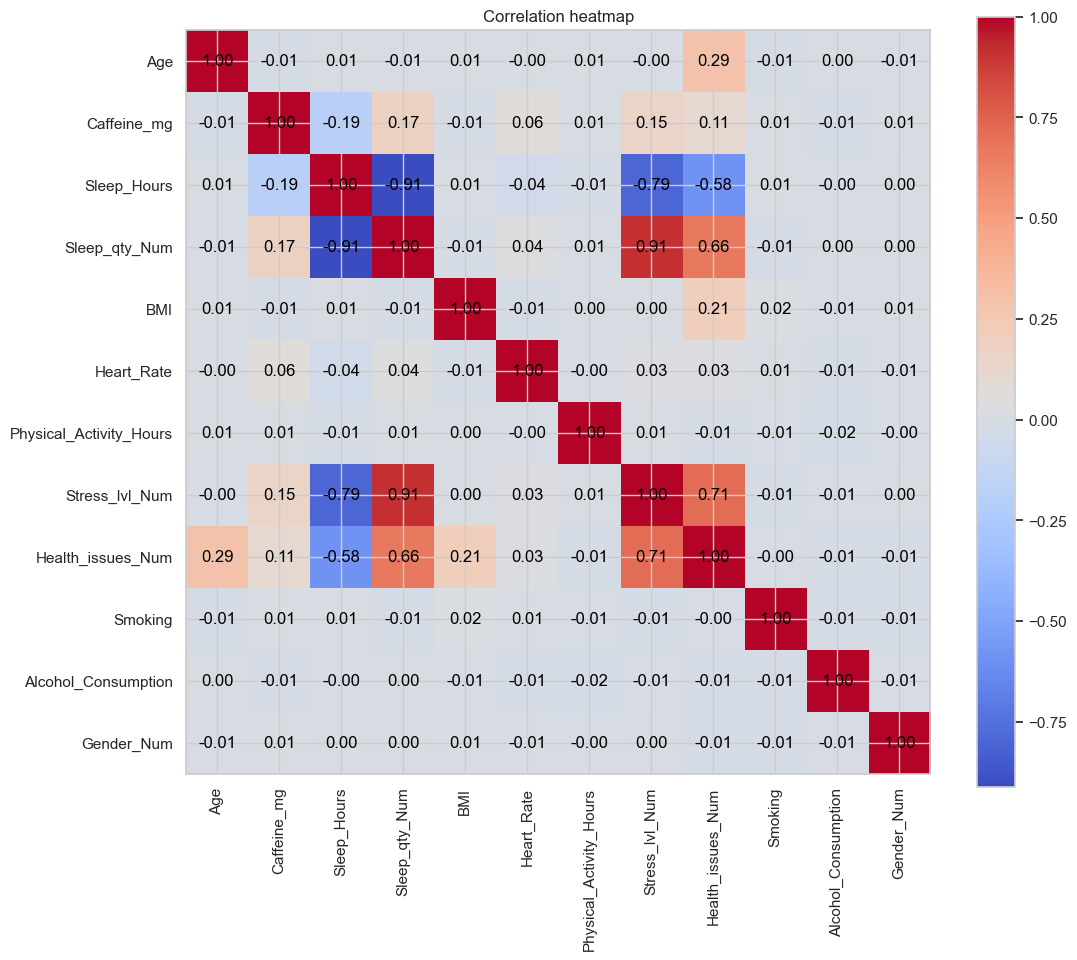


--- Bigger picture ---



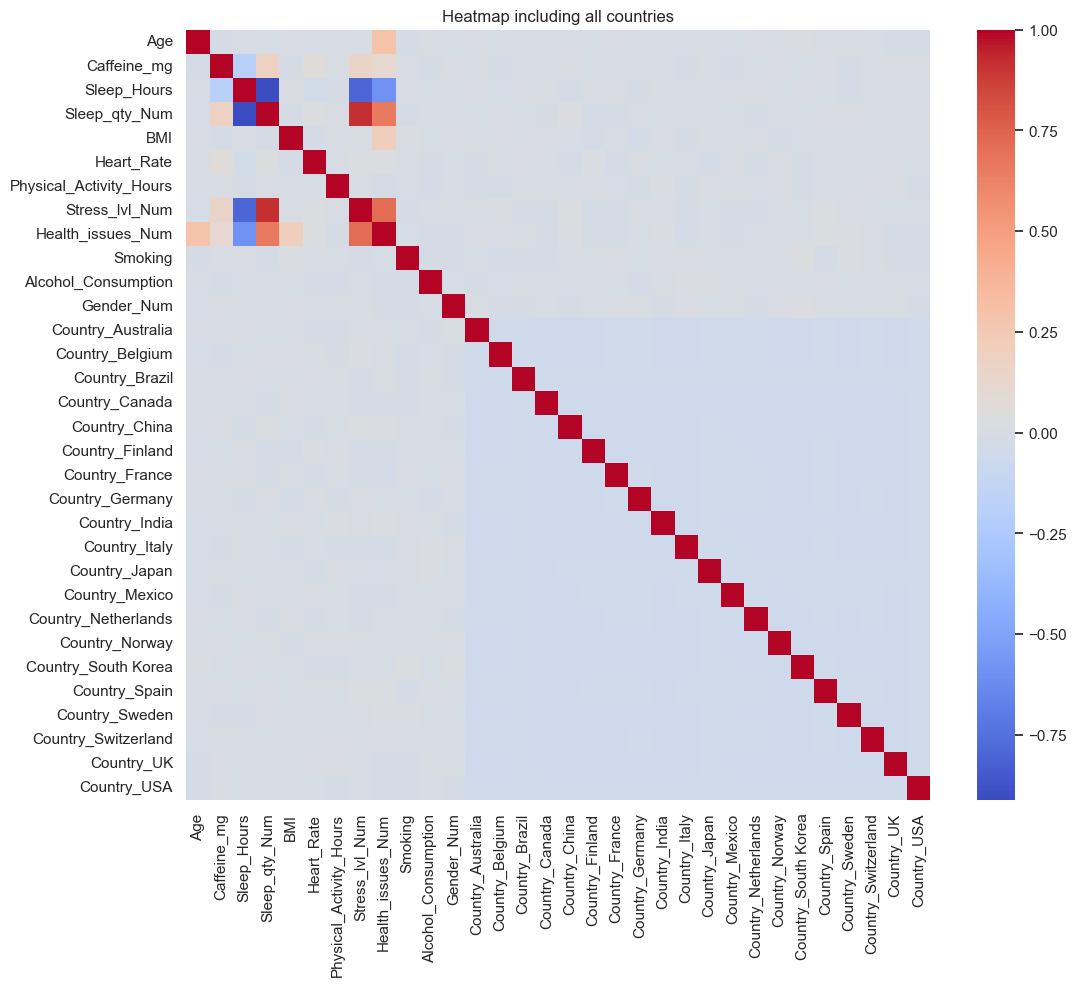

In [3]:
#### Small preparation / mapping for matrix to work ####

# First, fill any missing values (NaN) in 'Health_Issues' with the string 'None'
df['Health_Issues'] = df['Health_Issues'].fillna('None')

# Create mapping dictionaries
stress_map = {'Low': 0, 'Medium': 1, 'High': 2}
sleep_map = {'Excellent': 0, 'Good': 1, 'Fair': 2, 'Poor': 3}
health_map = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}
gender_map = {'Female': 0, 'Male': 1, 'Other': np.nan}

# Apply the mapping to create new numerical columns
df['Stress_lvl_Num'] = df['Stress_Level'].map(stress_map)
df['Sleep_qty_Num'] = df['Sleep_Quality'].map(sleep_map)
df['Health_issues_Num'] = df['Health_Issues'].map(health_map)
df['Gender_Num'] = df['Gender'].map(gender_map)

NumDf = df[[
    'Age',
    #'Coffee_Intake',
    'Caffeine_mg',
    'Sleep_Hours',
    'Sleep_qty_Num',
    'BMI',
    'Heart_Rate',
    'Physical_Activity_Hours',
    'Stress_lvl_Num',
    'Health_issues_Num',
    'Smoking',
    'Alcohol_Consumption',
    'Gender_Num'
]]

corr = NumDf.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)

for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title("Correlation heatmap")
plt.show()

# Show the matrix from a broader aspect
print("\n--- Bigger picture ---\n")

df_country_dummies = pd.get_dummies(df['Country'], prefix='Country')
df_merged = pd.concat([NumDf, df_country_dummies], axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(df_merged.corr(), cmap='coolwarm')
plt.title('Heatmap including all countries')
plt.show()

A preliminary correlation analysis of categorical features, such as `Country`, revealed weak relationships in comparison with upper left corner with features such as `Health_issues_Num` and `Stress_lvl_Num`. Before deciding to exclude these variables from our models, we will conduct a similar analysis for the `Occupation` feature. Exploring the relationship between occupation and health outcomes is particularly relevant to our project's secondary goal and warrants a closer look.

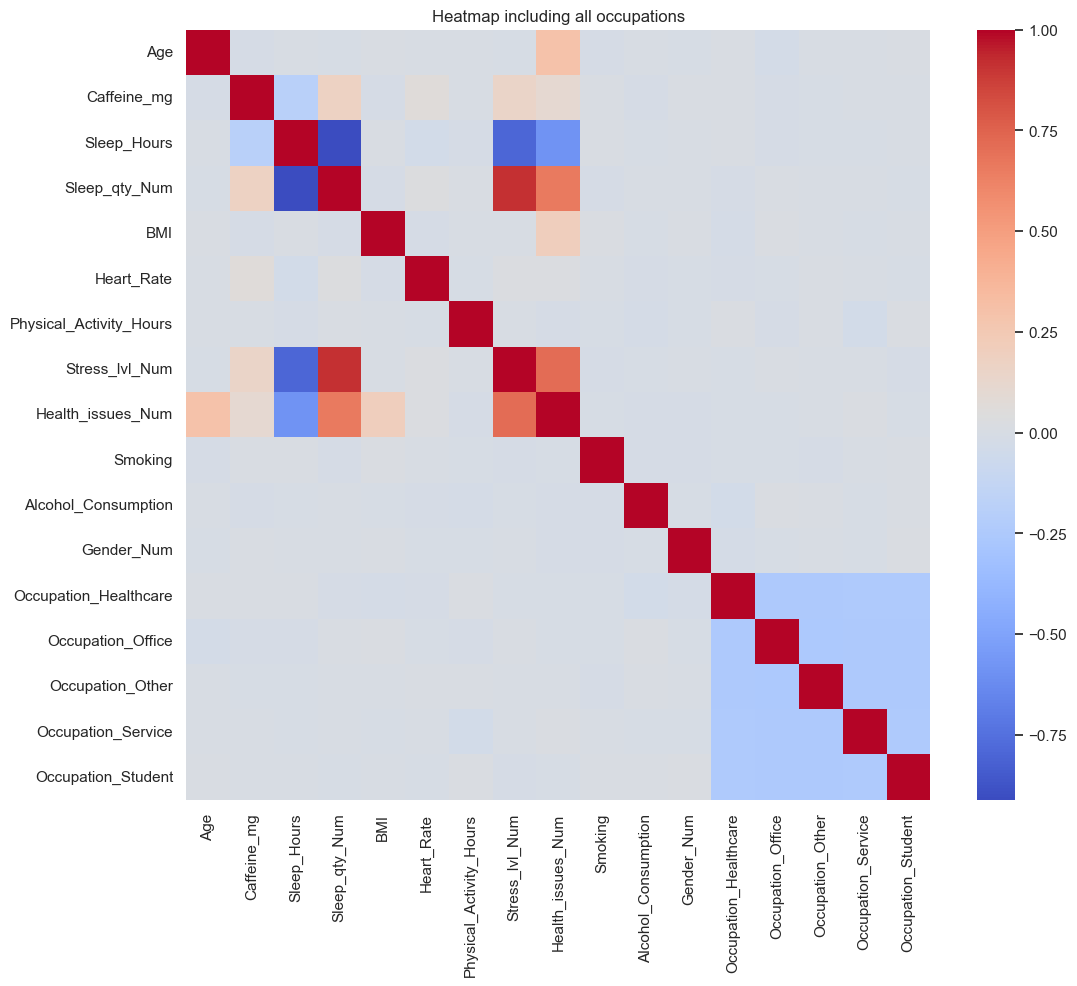

In [4]:
df_occupation_dummies = pd.get_dummies(df['Occupation'], prefix='Occupation')
df_merged2 = pd.concat([NumDf, df_occupation_dummies], axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap( df_merged2.corr(), cmap='coolwarm')

plt.title('Heatmap including all occupations')
plt.show()

New heatmap did not reveal any strong relationships. Therefore, uncorrelated data will be excluded to present our findings in a more readable format.

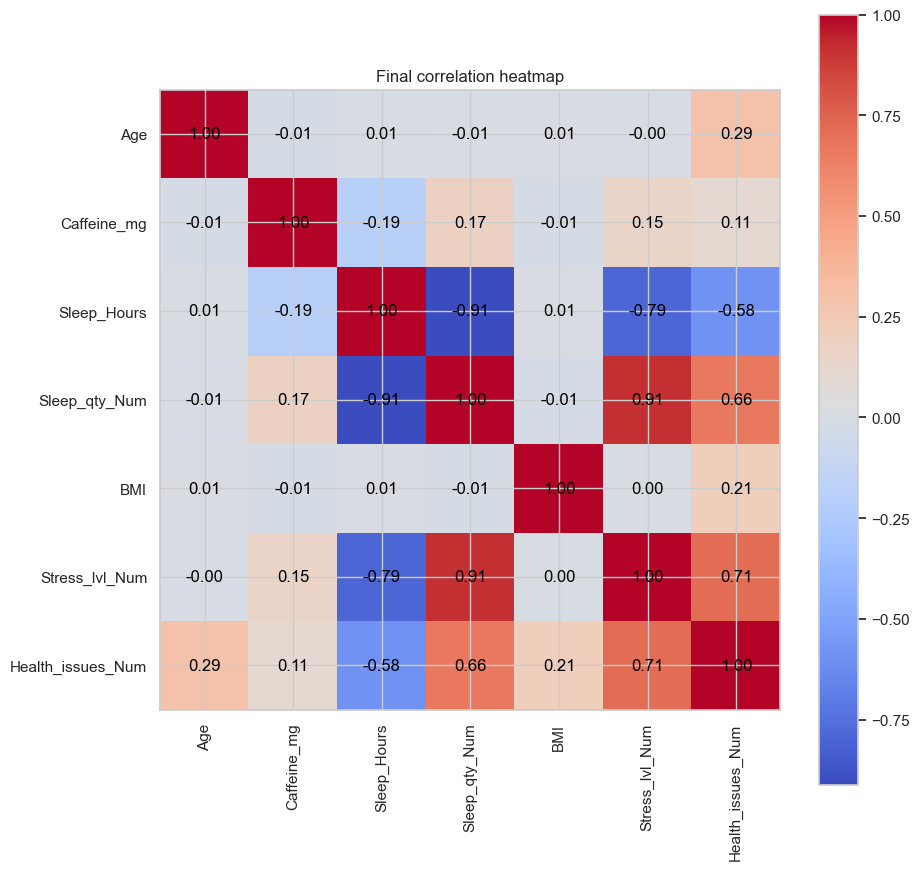

In [5]:
corr = df[[
    'Age',
    #'Coffee_Intake',
    'Caffeine_mg',
    'Sleep_Hours',
    'Sleep_qty_Num',
    'BMI',
    #'Heart_Rate',
    #'Physical_Activity_Hours',
    'Stress_lvl_Num',
    'Health_issues_Num',
    #'Smoking',
    #'Alcohol_Consumption'
]].corr()


plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)

for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title("Final correlation heatmap")
plt.show()

Based on the preliminary correlation analysis, `Coffee_Intake` doesn't appear to be the most dominant factor, suggesting its individual impact might be less significant than other lifestyle variables. However, we will investigate this further during the modeling phase.

Conversely, the `Health_Issues` feature shows stronger correlations with multiple factors. This indicates that a predictive model built to estimate health outcomes should perform reasonably well, as there are clear patterns in the data for the model to learn from. Based on the results, we can work with coffee intake, and even though it doesn't seem to be as impactful as other factors, we want to confirm whether this holds true.

## Data preparation

We established that the dataset is clean and well-structured, with minor inconsistencies having already been resolved. The primary task in this phase is to define the specific binary outcomes suitable for logistic regression modeling, utilizing the mappings created during the exploratory analysis.

While the initial heatmap analysis suggested that caffeine's influence might be not significant, we will still proceed with our goal to identify a potential risk threshold. For this analysis, we have chosen a "middle ground" approach with the lowest possible values to define a negative outcome:

- **Stress**: A `Stress_Level` of 'Medium' or higher will be considered a negative outcome.
- **Sleep**: A `Sleep_Quality` of 'Fair' or worse will be considered a negative outcome.
- **Health**: The presence of 'Mild' `Health_Issues` or worse will be considered a negative outcome.

In [6]:
#### Create three distinct binary targets ####

# Target 1: Is the person experiencing high stress?
df['Is_High_Stress'] = (df['Stress_lvl_Num'] >= 1).astype(int) # highest alternative 2
# Target 2: Is the person experiencing poor sleep?
df['Is_Poor_Sleep'] = (df['Sleep_qty_Num'] >= 2).astype(int) # highest alternative 3 - used to see the difference with stress
# Target 3: Does the person have any health issues ?
df['Has_Health_Issues'] = (df['Health_issues_Num'] >= 1).astype(int) # highest alternative 3 (2 was used during initial testings)

print("\n--- Summary table ---\n")

df[['Stress_Level', 'Stress_lvl_Num', 'Is_High_Stress', 'Sleep_Quality', 'Sleep_qty_Num',  'Is_Poor_Sleep', 'Health_Issues', 'Health_issues_Num', 'Has_Health_Issues']].head()


--- Summary table ---



,Stress_Level,Stress_lvl_Num,Is_High_Stress,Sleep_Quality,Sleep_qty_Num,Is_Poor_Sleep,Health_Issues,Health_issues_Num,Has_Health_Issues
0,Low,0,0,Good,1,0,None,0,0
1,Low,0,0,Good,1,0,None,0,0
2,Medium,1,1,Fair,2,1,Mild,1,1
3,Low,0,0,Good,1,0,Mild,1,1
4,Medium,1,1,Fair,2,1,Mild,1,1


The table above summarizes the new columns created during the data preparation phase. It provides a clear comparison between the original categorical data and the newly engineered numerical features that will be used for modeling.

## Modeling

We now focus on building predictive models to explore how much caffeine is needed in order to negatively impact one's sleep, stress, and health levels, as well as identifying the key factors in predicting health issues. Each model is trained using an appropriate machine learning method, and the dataset is split into training and validation sets when it proves significance to evaluate model performance and prevent overfitting.

### Threshold for harmful caffeine intake

To achieve a threshold for caffeine intake before damaging results, three seperate logistic regression models are trained – one for each target variable – allowing us to plot and compare their results in a graph. The targets are `Is_High_Stress`, `Is_Poor_Sleep`, and `Has_Health_Issues`.

In [7]:
#### Initial phase to define common and useful variables ####

randomstate = 42

# Feature for caffeine amount
X = df[['Caffeine_mg']]

# Caffeine range for plotting and mapped into a DataFrame
caffeine_range = np.linspace(0, df['Caffeine_mg'].max(), 500).reshape(-1, 1)
caffeine_range_df = pd.DataFrame(caffeine_range, columns=['Caffeine_mg'])

#### Predicting three in one

The goal is to predict the probability of negative health outcomes based on an individual’s daily caffeine intake, and we will do this by building three models iteratively for each feature in one go.

In [8]:
# List of target variables and their descriptive labels
targets = [
    {'column': 'Is_High_Stress', 'label': 'High Stress'},
    {'column': 'Is_Poor_Sleep', 'label': 'Poor Sleep'},
    {'column': 'Has_Health_Issues', 'label': 'Health Issues'}
]

# Dictionary to store results for plotting
plot_data = {}

# Main loop for processing
for target in targets:
    print(f"--- Processing: {target['label']} ---")

    # 1. Select the feature (target variable)
    y = df[target['column']]

    # 2. Split data for the current model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate)

    # 3. Train the model
    log_reg = LogisticRegression(random_state=randomstate)
    log_reg.fit(X_train, y_train)

    # 4. Predict probabilities on the caffeine range
    probs = log_reg.predict_proba(caffeine_range_df)[:, 1]

    # Store probabilities for later plotting
    plot_data[target['label']] = {'probs': probs}

    # 5. Find and print the highest probability
    max_prob = probs.max()
    print(f"Maximum predicted probability for {target['label']}: {max_prob:.2%}")

    # 6. Find and print the tipping point (where probability crosses 50%)
    tipping_point = None
    try:
        # Find the first index where probability is >= 0.5
        tipping_point_index = np.where(probs >= 0.5)[0][0]
        tipping_point = caffeine_range[tipping_point_index][0]
        print(f"Tipping point for {target['label']}: ~{tipping_point:.0f} mg")
    except IndexError:
        print(f"Tipping point for {target['label']} was not found (probability never reached 50%).")

    # Store tipping point for later plotting
    plot_data[target['label']]['tipping_point'] = tipping_point

    print("\n")

--- Processing: High Stress ---
Maximum predicted probability for High Stress: 61.97%
Tipping point for High Stress: ~582 mg


--- Processing: Poor Sleep ---
Maximum predicted probability for Poor Sleep: 61.97%
Tipping point for Poor Sleep: ~582 mg


--- Processing: Health Issues ---
Maximum predicted probability for Health Issues: 64.10%
Tipping point for Health Issues: ~450 mg




#### Compare the results

By plotting all three probability curves on the same graph, we can visually compare them. The curve that rises fastest or has the lowest tipping point indicates the health aspect that is most sensitive to caffeine.

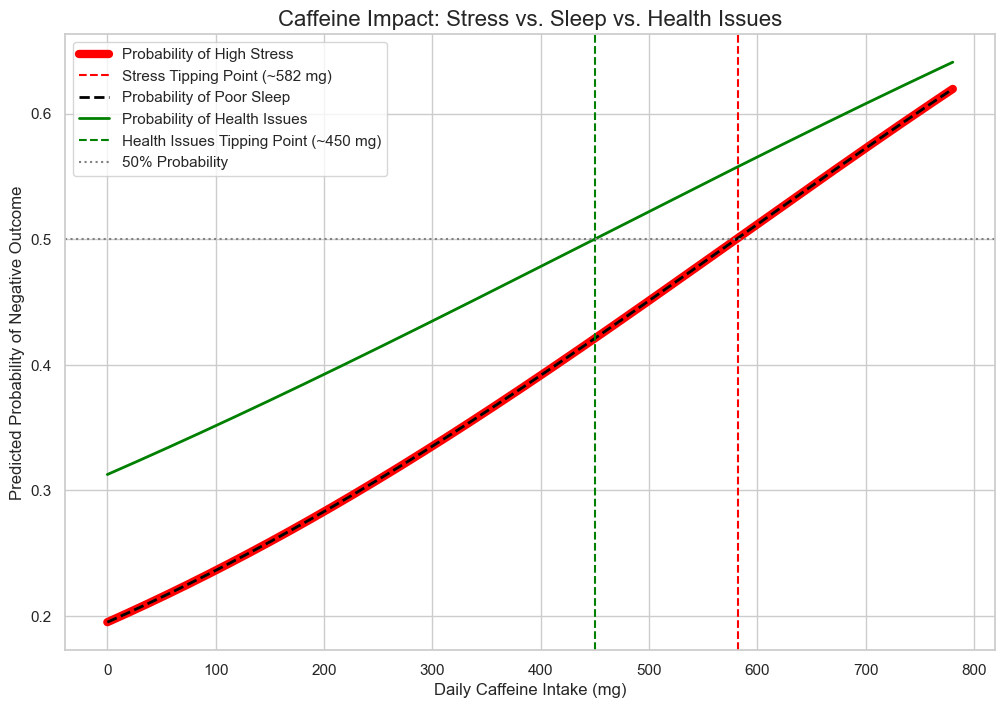

In [9]:
plt.figure(figsize=(12, 8))

# Example of extracting stored data from dictionary
# stress_probs = plot_data['High Stress']['probs']

# Plot for stress
plt.plot(caffeine_range, plot_data['High Stress']['probs'], label='Probability of High Stress', color='red', linewidth=6)
plt.axvline(x=plot_data['High Stress']['tipping_point'], color='red', linestyle='--', label=f'Stress Tipping Point (~{plot_data['Poor Sleep']['tipping_point']:.0f} mg)')

# Plot for sleep
plt.plot(caffeine_range, plot_data['Poor Sleep']['probs'], label='Probability of Poor Sleep', color='black', linestyle='--', linewidth=2)

# Plot for health issues
plt.plot(caffeine_range, plot_data['Health Issues']['probs'], label='Probability of Health Issues', color='green', linewidth=2)
plt.axvline(x=plot_data['Health Issues']['tipping_point'], color='green', linestyle='--', label=f'Health Issues Tipping Point (~{plot_data['Health Issues']['tipping_point']:.0f} mg)')

# Display the graph
plt.axhline(y=0.5, color='grey', linestyle=':', label='50% Probability')
plt.title('Caffeine Impact: Stress vs. Sleep vs. Health Issues', fontsize=16)
plt.xlabel('Daily Caffeine Intake (mg)', fontsize=12)
plt.ylabel('Predicted Probability of Negative Outcome', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Examining the graph, we can determine that `Is_High_Stress` and `Is_Poor_Sleep` show a perfect correlation. This outcome is due to the nature of our binary mapping, but also because the data is synthetic and does not account for humane "outliers", e.g. having excellent sleep despite experiencing high stress.

From the results, we can interpret that even a somewhat high of a caffeine intake (around 8-10 small cups of coffee) does not strongly correlate with increased stress levels or poor sleep. Within that range, the predicted probability of experiencing negative effects remains quite low.

However, for individuals who already have potential health issues, caffeine intake might worsen them and tip the probability of harmful effects over the 50% threshold. The negative consequences associated with caffeine consumption may essentially stack up to already existing issues.

### Key health predictors

A Random Forest Classifier is built to predict the likelihood of health issues and identify the key factors that influence the target variable `Health_Issues` the most. We are also interested in finding out how impactful caffeine consumption is in predicting health issues compared to other factors such as sleep, physical activity, stress, age, and BMI.

We use 10-fold cross-validation to ensure reliable performance evaluation, and we will later on examine feature importance to understand the key predictors for health issues.

#### Random Forest with cross-validation

We start by defining our features *X* and our target *y*. The features will contain all the lifestyle factors we want to analyze. `Smoking` and `Alcohol_Consumption` have been excluded as they are binary values with no context whether the consumption is high or very scarce, and so they are irrelevant to our analysis.

In [10]:
# Define features (X) and target (y)
X = df[['Caffeine_mg', 'Sleep_Hours', 'Physical_Activity_Hours', 'Stress_lvl_Num', 'Age', 'BMI']]
y = df['Health_Issues']

# Split the data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate, stratify=y)

# Create a Random Forest Classifier with 100 trees
rf_classifier = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=0.7, max_features=0.75, random_state=randomstate)

# Carry out 10-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10)

print(f"Average Accuracy: {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")

# Train the classifier
rf_classifier.fit(X_train, y_train)

Average Accuracy: 99.84% (+/- 0.15%)


RandomForestClassifier(max_features=0.75, max_samples=0.7, random_state=42)

#### Confusion matrix

Before analyzing the model's feature importance rankings, we need to evaluate how well it performs in its predictive task. By generating a confusion matrix from the test data, we can determine if the model is able to predict health issues correctly.

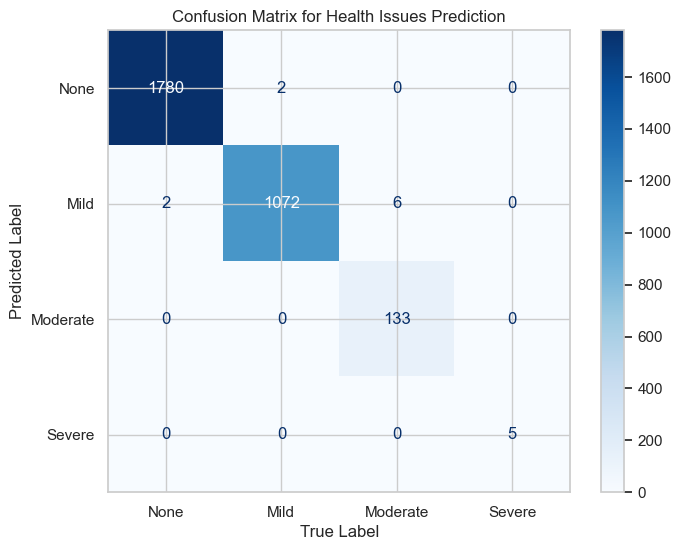

In [11]:
# Generate predictions for the confusion matrix
y_pred = rf_classifier.predict(X_test)

# Sort the present labels according to the health_map values
unique_labels = sorted(y.unique(), key=lambda label: health_map[label])

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.T, display_labels=unique_labels) # transpose the matrix to swap the axes

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix for Health Issues Prediction')

# Set labels to reflect the new orientation (Predicted on Y, True on X)
ax.set_ylabel('Predicted Label')
ax.set_xlabel('True Label')

plt.show()

The model performs very well according to the confusion matrix, with only a few incorrectly predicted targets. This helps confirm that the model’s predictions are reliable before interpreting its feature importance scores.

#### Feature importance

As the last, and probably most important step, we will generate the importance score for each feature from the trained model and create a bar chart to easily compare them.

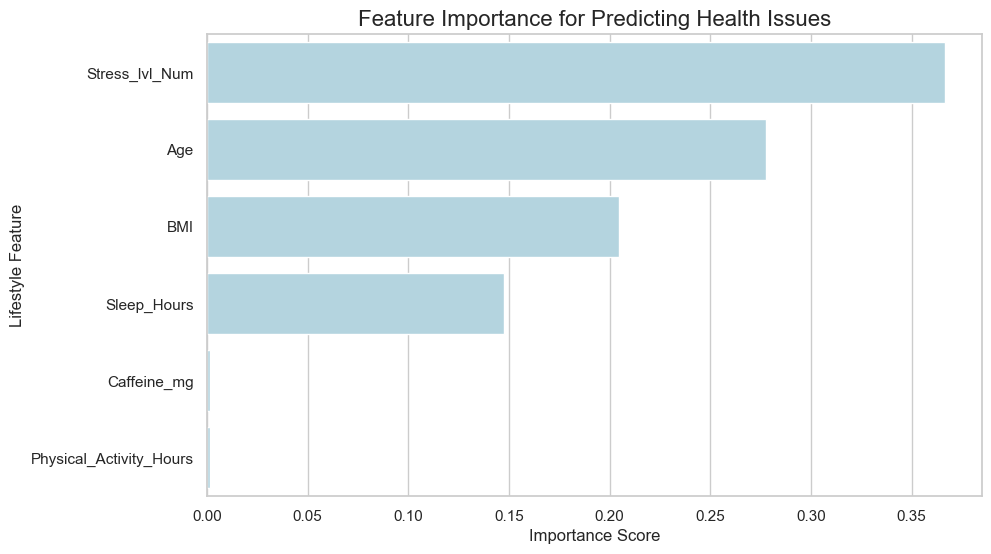

--- Ranked Feature Importance ---
                   Feature  Importance
3           Stress_lvl_Num    0.366621
4                      Age    0.277718
5                      BMI    0.204686
1              Sleep_Hours    0.147670
0              Caffeine_mg    0.001745
2  Physical_Activity_Hours    0.001559


In [12]:
# Get feature importance from the trained model
importance = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='lightblue')
plt.title('Feature Importance for Predicting Health Issues', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Lifestyle Feature', fontsize=12)
plt.show()

# Print the ranked list
print("--- Ranked Feature Importance ---")
print(feature_importance_df)

According to the chart of feature importance, caffeine intake `Caffeine_mg` is extremely insigificant in comparison to the other factors. The highest in importance to predicting health issues are stress, age, BMI, and sleep respectively.

## Evaluation

#### Model performance

The Logistic Regression and Random Forest Classifier models proved to be highly accurate and precise when it came to predicting relationships between caffeine and health factors. The data preparation phase was done well to reflect our requirements during the modeling phase, and we managed to utilize the dataset to the best of our ability and needs concerning the research questions. However, although our models were tested using seperate data from what they were trained with, the reliability of its accuracy predicting real-life data is unverified as the models were built on synthetic data. It's still worth emphasizing the fact that the models are well structured and could be utilized with authentic data as is. 

#### Business requirements

**The first research question was to determine a threshold for harmful caffeine intake.**

Through Logistic Regression modeling, we managed to identify a probable threshold for when caffeine consumption would cause damage to sleep quality, stress levels, and health.

| Target         | Tipping point of caffeine intake (mg) | Maximum predicted probability with increasing caffeine intake (%) |
|----------------|---------------------------------------|-------------------------------------------------------------------|
| High Stress    | 582                                   | 61.97                                                             |
| Poor Sleep     | 582                                   | 61.97                                                             |
| Health Issues  | 450                                   | 64.10                                                             |

The probability of these issues emerging as caffeine intake increases stayed relatively low, but this predictive model could still be very well utilized.

**The second research question was to find the key health predictors and compare them with caffeine intake.**

Using Random Forest Classifier and analyzing feature importance chart, we identified key factors, such as stress level, age, and sleep, in predicting health issues. When examining the scores of importance, caffeine proved to be noticeably less significant compared to other factors in their predictive impact.

#### The process and what we learned

The project work was carried out using the CRISP-DM process model, and the things we learned throughout the course can be reflected through it.
- **Business Understanding phase:** We discussed and decided on a topic that interested us and was realistic to implement. Our secondary goal had to be excluded in the end as our dataset did not meet the requirements we would've needed to carry it out.
  
- **Data Understanding phase:** The most important lesson was to pay attention to data quality – even if data is clean and free of outliers, it's not necessarily a sufficient dataset for our needs. Even though we had many explanatory variables, the data was synthetic and thus overly simplified, lacking natural complexity.

- **Data Preparation phase:** Through this phase we learned that the way data is prepared strongly influences the results that the models produce. Our mapping of the stress, sleep, and health issues heavily affected the threshold for safe caffeine intake, as well as the perfect correlation of having high levels of both sleep and stress.

- **Modeling phase:** We realized that the same problem can be modeled in multiple ways, and these choices should always be made on a project-by-project basis. We found that Logistic Regression and Random Forest Classifier provided the best performance while also meeting the business criteria.

- **Evaluation and Deployment phase:** Assessing our models’ performance and whether it met the set requirements was critical during the entire process.

## Deployment

A potential result of this project is the development of an application that monitors users’ daily habits and provides tailored insight on their health, possibly suggestions on their caffeine intake. This application could help users in making more informed lifestyle choices and support early detection of possibly harmful habits.

However, to assess its actual effectiveness, a much broader dataset would be needed. Even though our model was trained on synthetic data that is sufficient in making a theoretical system, a dataset containing real, human input is required for a reliable model to be used in practice. Furthermore, expanding the dataset would allow for a more thorough comparison of factors such as alcohol consumption, smoking habits, and physical activity levels on health. Having a diverse range of factors that can be examined and compared is essential to validate our findings and develop a more reliable system that truly reflects real world lifestyles.

Conclusively, collecting a wider range of authentic data and examining its factors will be key steps toward developing an application that reflects and can be applied to real-life patterns.